In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter, PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction

In [3]:
df = pd.read_pickle("../../data/interim/02_outliers_removed_chauvenets.pkl")

In [8]:
predictor_columns = df.columns[:6]

In [9]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9005 non-null   float64
 1   acc_y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyr_x        8984 non-null   float64
 4   gyr_y        8938 non-null   float64
 5   gyr_z        8945 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 739.0+ KB


In [13]:
for col in predictor_columns:
    df[col] = df[col].interpolate()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        9009 non-null   float64
 4   gyr_y        9009 non-null   float64
 5   gyr_z        9009 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 739.0+ KB


<AxesSubplot: xlabel='epoch (ms)'>

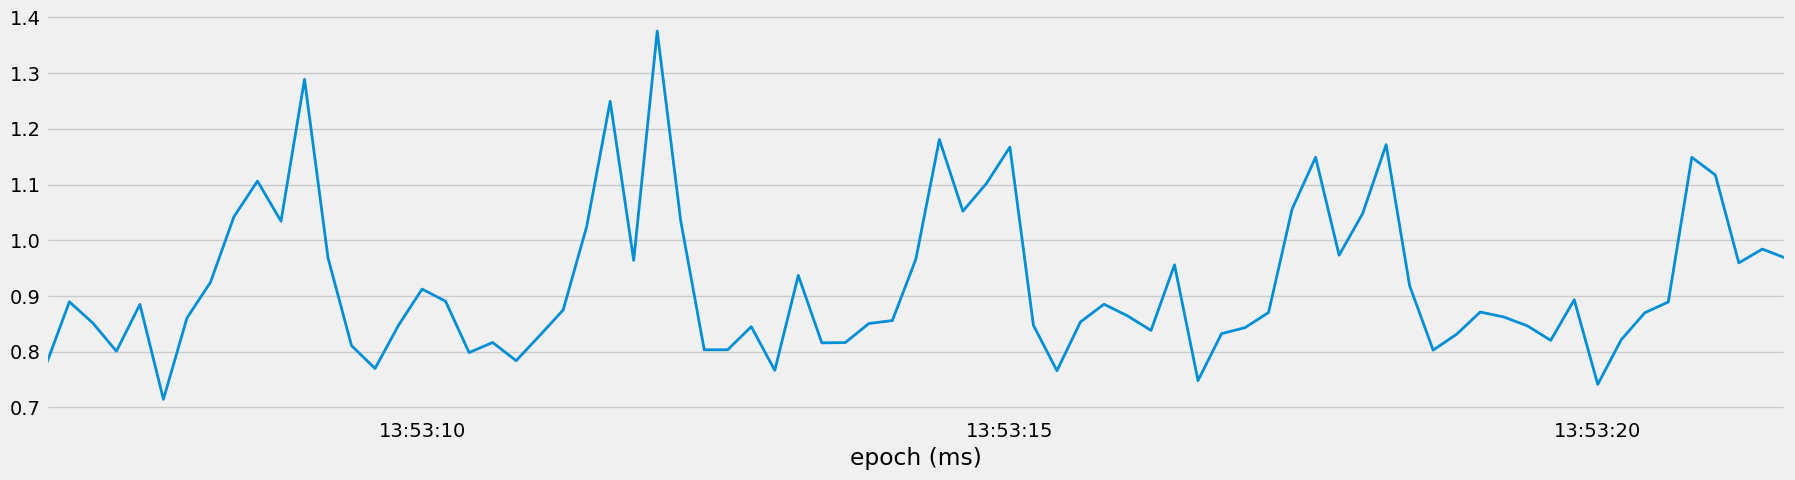

In [15]:
df[df["set"] == 25]["acc_y"].plot()

<AxesSubplot: xlabel='epoch (ms)'>

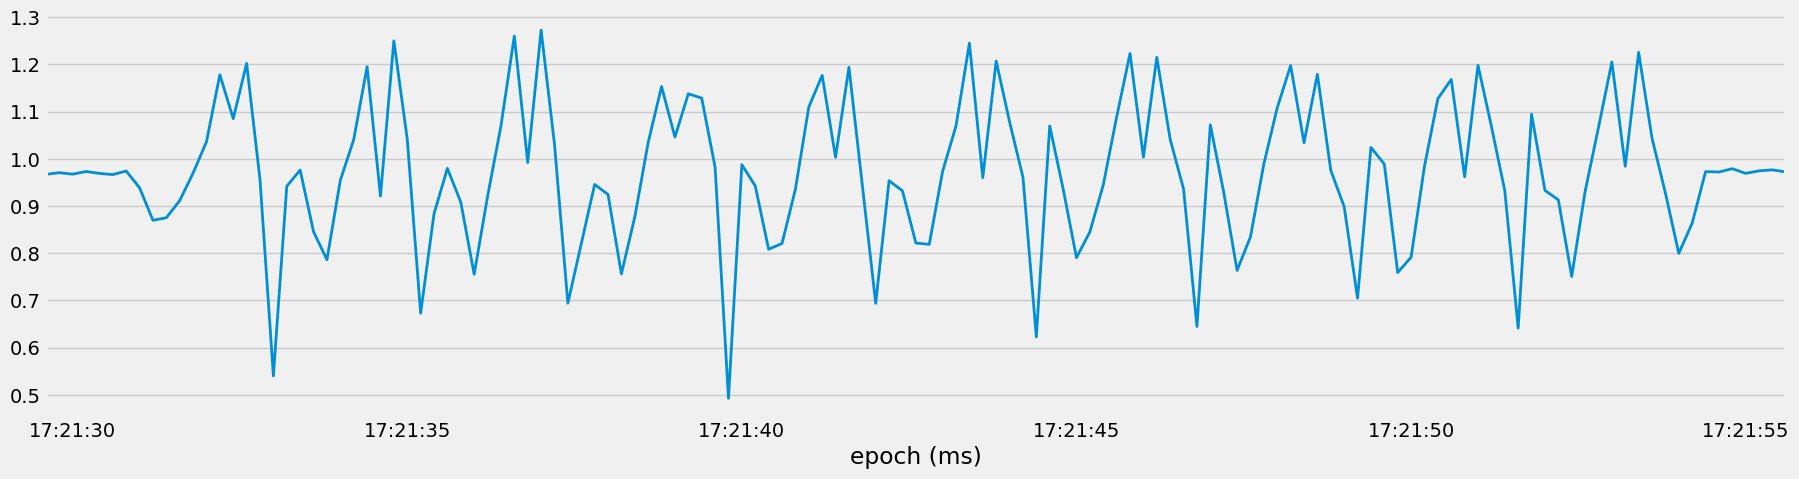

In [16]:
df[df["set"] == 50]["acc_y"].plot()

In [17]:
duration = df[df["set"] == 1].index[-1] - df[df["set"] == 1].index[0]

In [19]:
duration.seconds

20

In [20]:
for s in df["set"].unique():
    start = df[df["set"] == s].index[0]
    stop = df[df["set"] == s].index[-1]
    duration = stop - start
    df.loc[(df["set"] == s), "duration"] = duration.seconds

In [21]:
df

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,64,16.0
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,64,16.0
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,64,16.0
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,64,16.0
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,64,16.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,71,19.0
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,71,19.0
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,71,19.0


In [22]:
df.groupby(["category"])["duration"].mean()

category
heavy       14.743501
medium      24.942529
sitting     33.000000
standing    39.000000
Name: duration, dtype: float64

In [23]:
duration_df = df.groupby(["category"])["duration"].mean()

In [24]:
df_lowpass = df.copy()

In [25]:
LowPass = LowPassFilter()

In [26]:
fs = 1000 / 200

In [27]:
cutoff = 1

In [28]:
df_lowpass = LowPass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order=5)

In [29]:
df_lowpass

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,acc_y_lowpass
epoch (ms),,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,64,16.0,0.977022
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,64,16.0,0.962269
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,64,16.0,0.966368
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,64,16.0,0.979343
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,64,16.0,0.966609
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,71,19.0,-1.010877
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,71,19.0,-0.986139
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,71,19.0,-1.026145


In [30]:
subset = df_lowpass[df_lowpass["set"] == 45]

In [33]:
print(subset["label"][0])

dead


In [34]:
subset

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,acc_y_lowpass
epoch (ms),,,,,,,,,,,,
2019-01-16 19:30:35.000,0.081000,-1.054000,0.043000,3.91480,-18.08540,-2.20740,E,dead,medium,45,34.0,-1.044719
2019-01-16 19:30:35.200,0.081333,-1.036333,0.034333,-11.90240,-6.85360,0.20720,E,dead,medium,45,34.0,-1.032462
2019-01-16 19:30:35.400,0.020500,-0.981500,-0.098500,-16.78080,-10.02440,-7.36600,E,dead,medium,45,34.0,-1.007302
2019-01-16 19:30:35.600,0.095667,-1.039667,-0.056667,1.25600,0.28060,-3.47560,E,dead,medium,45,34.0,-0.999612
2019-01-16 19:30:35.800,0.112500,-1.019000,-0.066500,1.07320,-11.71960,0.30480,E,dead,medium,45,34.0,-1.035731
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-16 19:31:08.800,0.142000,-1.236667,-0.055333,11.36600,-24.65250,-16.81700,E,dead,medium,45,34.0,-1.188433
2019-01-16 19:31:09.000,0.078500,-1.036000,0.087500,28.25620,-40.43920,-10.78020,E,dead,medium,45,34.0,-1.059614
2019-01-16 19:31:09.200,0.094000,-0.944667,0.130000,79.54900,-40.26830,-18.52440,E,dead,medium,45,34.0,-0.863851


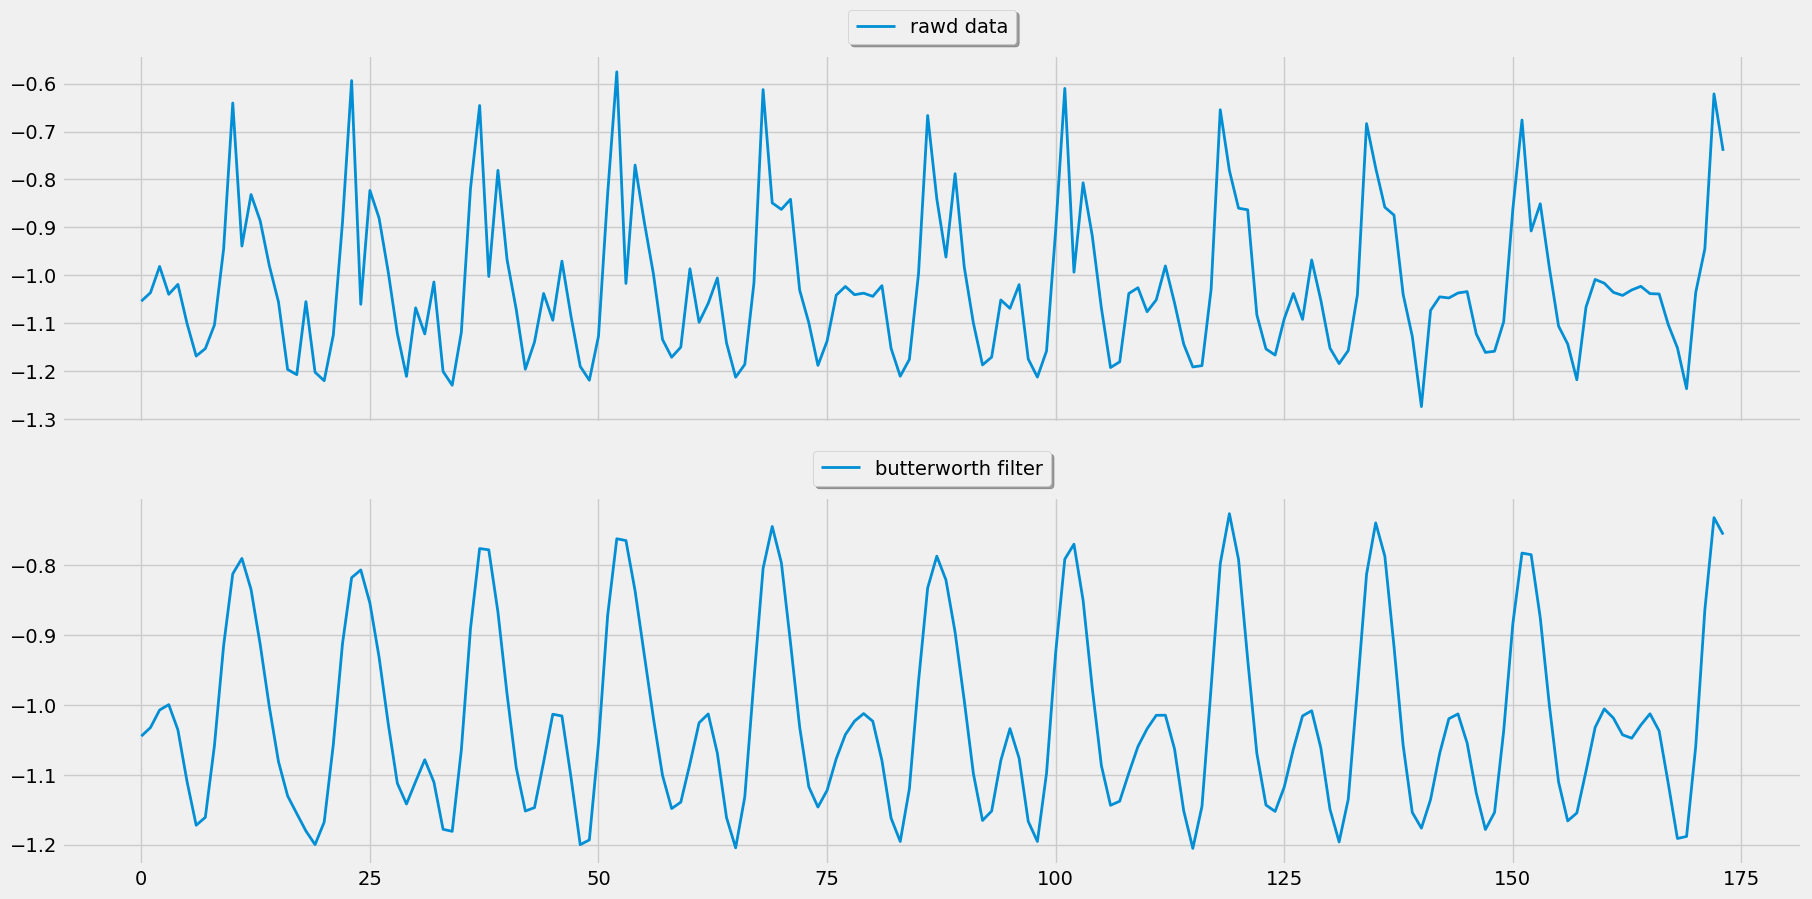

In [35]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
ax[0].plot(subset["acc_y"].reset_index(drop=True), label="rawd data")
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="butterworth filter")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

dead


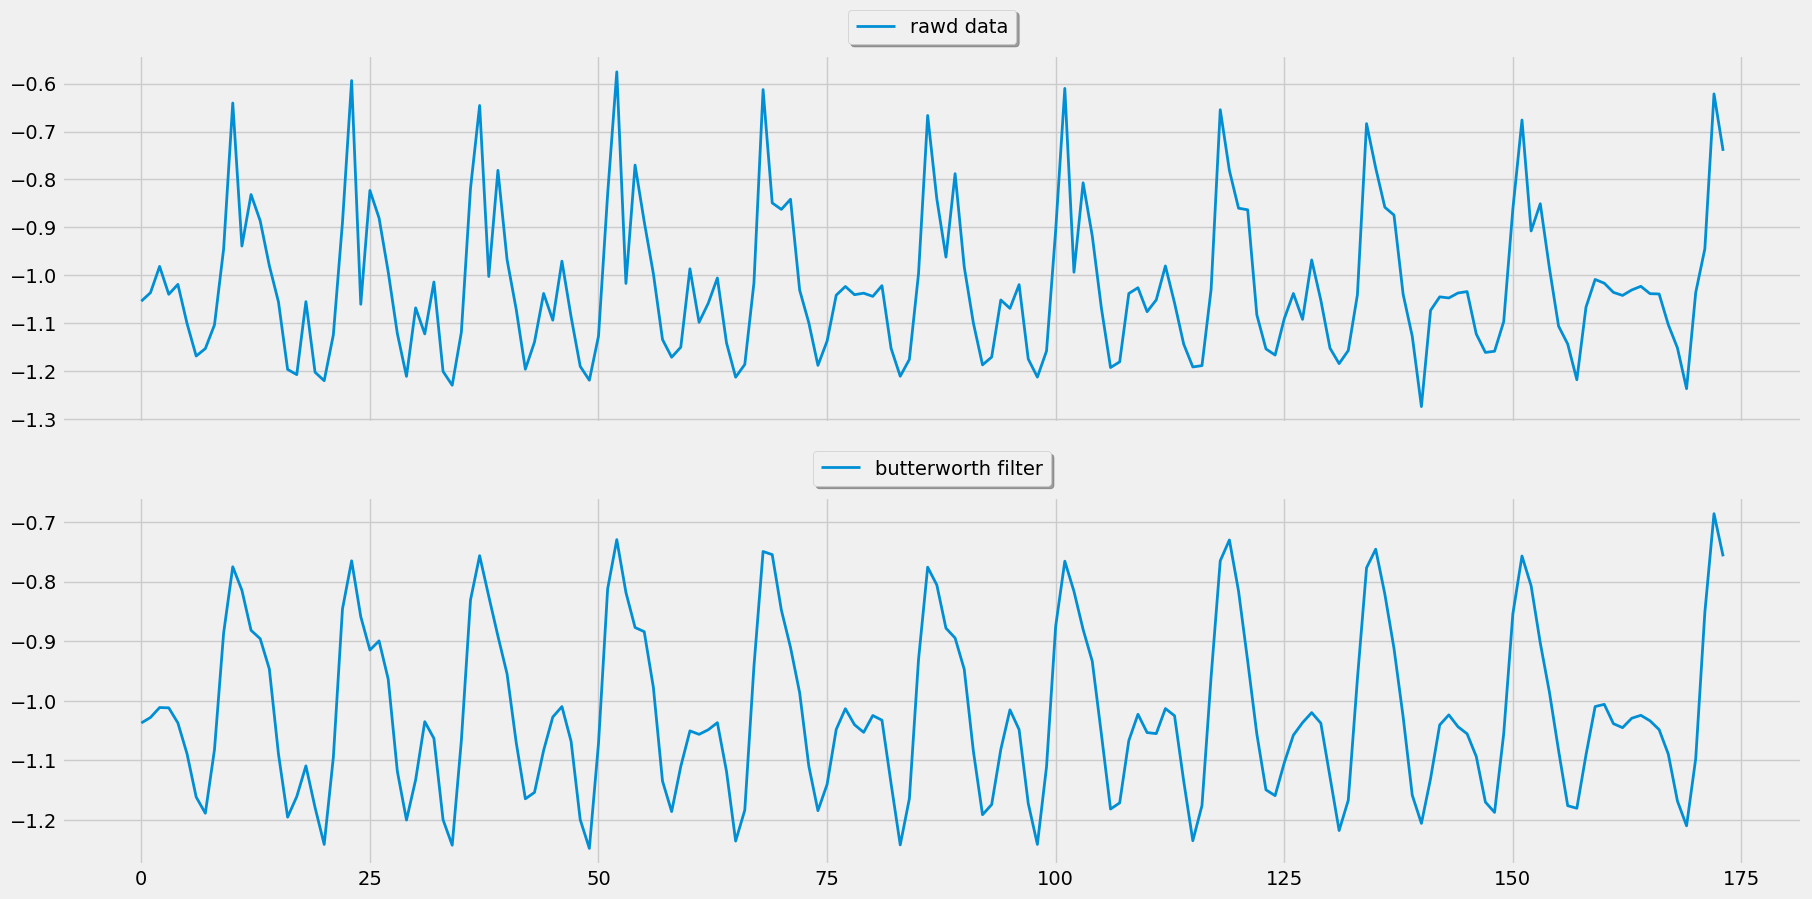

In [36]:
cutoff = 1.3
df_lowpass = LowPass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order=5)
subset = df_lowpass[df_lowpass["set"] == 45]
print(subset["label"][0])
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
ax[0].plot(subset["acc_y"].reset_index(drop=True), label="rawd data")
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="butterworth filter")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

dead


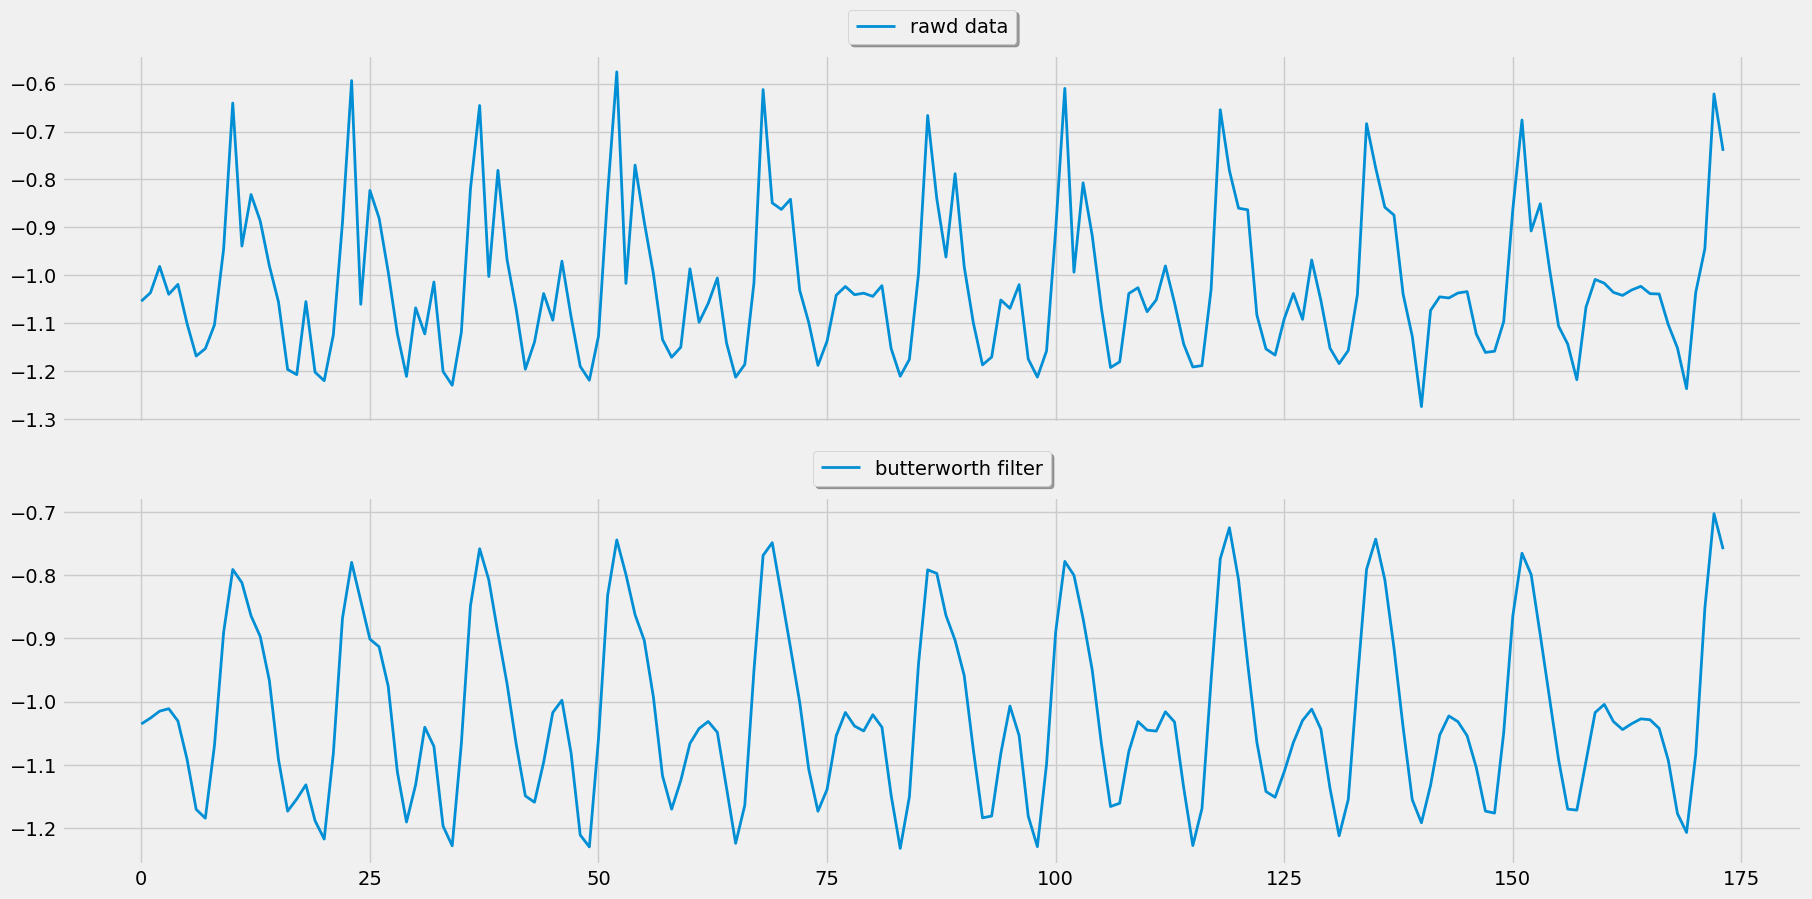

In [37]:
cutoff = 1.2
df_lowpass = LowPass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order=5)
subset = df_lowpass[df_lowpass["set"] == 45]
print(subset["label"][0])
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
ax[0].plot(subset["acc_y"].reset_index(drop=True), label="rawd data")
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="butterworth filter")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

In [38]:
for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5)
    df_lowpass[col] = df_lowpass[col + "_lowpass"]
    del df_lowpass[col + "_lowpass"]

In [39]:
df_lowpass

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,64,16.0
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,64,16.0
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,64,16.0
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,64,16.0
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,64,16.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,71,19.0
2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,71,19.0
2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,71,19.0


In [40]:
PCA = PrincipalComponentAnalysis()

In [41]:
df_pca = df_lowpass.copy()

In [42]:
df_pca

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,64,16.0
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,64,16.0
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,64,16.0
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,64,16.0
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,64,16.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,71,19.0
2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,71,19.0
2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,71,19.0


In [43]:
pc_values = PCA.determine_pc_explained_variance(df_pca, predictor_columns)

In [44]:
pc_values

array([0.58094932, 0.27090665, 0.06427472, 0.05519685, 0.01836808,
       0.01030437])

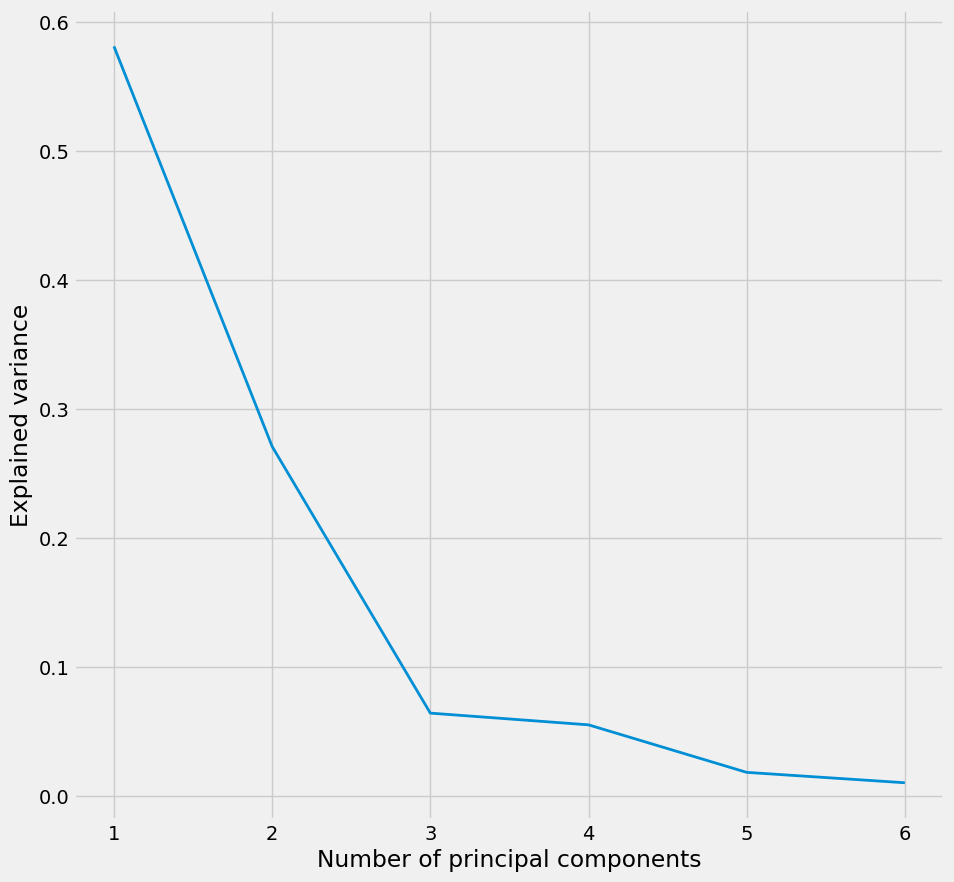

In [46]:
plt.figure(figsize=(10, 10))
plt.plot(range(1, len(predictor_columns) + 1), pc_values)
plt.xlabel("Number of principal components")
plt.ylabel("Explained variance")
plt.show()

In [48]:
df_pca = PCA.apply_pca(df_pca, predictor_columns, 3)

In [49]:
df_pca

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3
epoch (ms),,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,64,16.0,-0.317491,-0.075816,0.070520
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,64,16.0,-0.315555,-0.075282,0.070565
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,64,16.0,-0.314780,-0.081915,0.065980
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,64,16.0,-0.316880,-0.090205,0.060065
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,64,16.0,-0.317350,-0.095463,0.063173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,71,19.0,0.346775,-0.147540,-0.051285
2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,71,19.0,0.362725,-0.146231,-0.059154
2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,71,19.0,0.372734,-0.153069,-0.058939


<AxesSubplot: xlabel='epoch (ms)'>

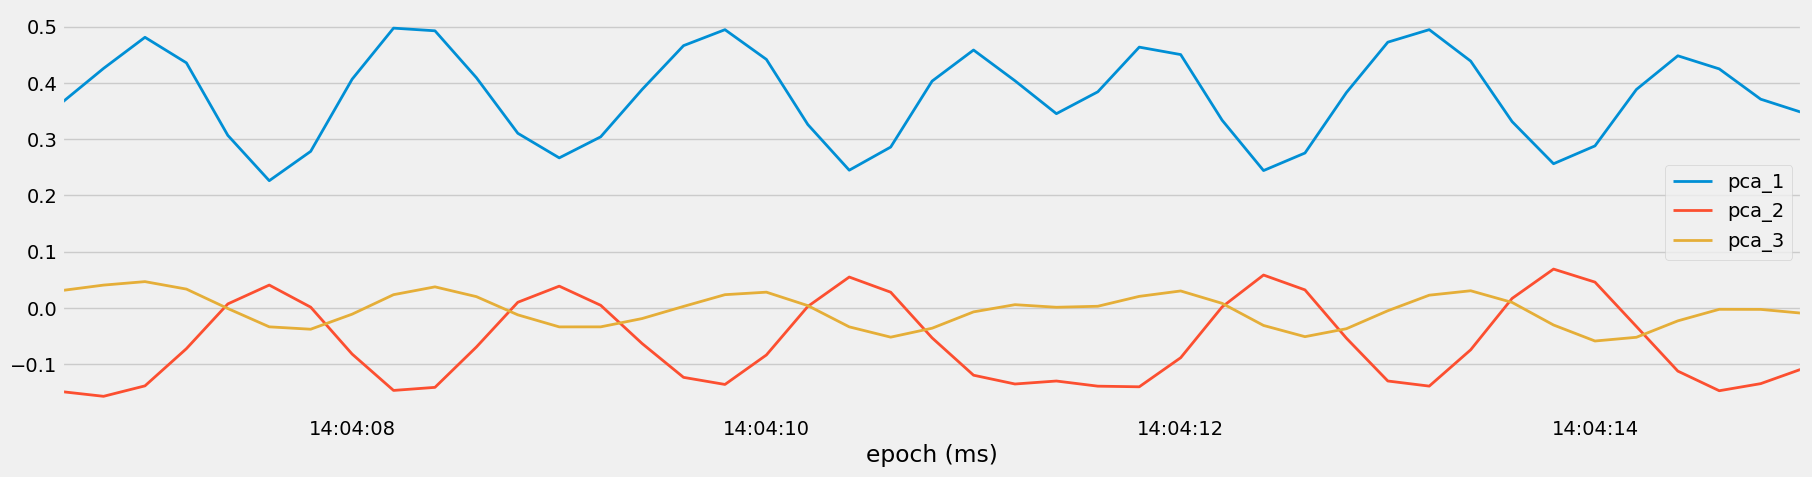

In [50]:
subset = df_pca[df_pca["set"] == 35]
subset[["pca_1", "pca_2", "pca_3"]].plot()

In [51]:
df_squared = df_pca.copy()

In [52]:
acc_r = df_squared["acc_x"] ** 2 + df_squared["acc_y"] ** 2 + df_squared["acc_z"] ** 2
gyr_r = df_squared["gyr_x"] ** 2 + df_squared["gyr_y"] ** 2 + df_squared["gyr_z"] ** 2

In [53]:
acc_r

epoch (ms)
2019-01-11 15:08:05.200    0.959754
2019-01-11 15:08:05.400    0.946009
2019-01-11 15:08:05.600    0.933991
2019-01-11 15:08:05.800    0.939616
2019-01-11 15:08:06.000    0.943867
                             ...   
2019-01-20 17:33:27.000    0.956060
2019-01-20 17:33:27.200    1.047432
2019-01-20 17:33:27.400    1.112595
2019-01-20 17:33:27.600    1.089380
2019-01-20 17:33:27.800    1.072985
Length: 9009, dtype: float64

In [54]:
df_squared["acc_r"] = np.sqrt(acc_r)
df_squared["gyr_r"] = np.sqrt(gyr_r)

In [55]:
subset = df_squared[df_squared["set"] == 14]

In [56]:
subset

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,,,,,
2019-01-18 16:51:41.400,0.121532,0.823898,0.510110,-0.507471,-1.024673,0.695113,D,squat,medium,14,26.0,-0.241318,0.277885,-0.015889,0.976622,1.338157
2019-01-18 16:51:41.600,0.117616,0.803465,0.540826,0.289669,-0.924885,0.972519,D,squat,medium,14,26.0,-0.233865,0.294494,-0.024753,0.975645,1.372994
2019-01-18 16:51:41.800,0.116314,0.801156,0.540791,1.251595,-0.942633,1.104231,D,squat,medium,14,26.0,-0.233160,0.294157,-0.024546,0.973568,1.916865
2019-01-18 16:51:42.000,0.115888,0.809614,0.530965,1.568579,-1.140324,1.020404,D,squat,medium,14,26.0,-0.236331,0.288608,-0.021824,0.975104,2.191347
2019-01-18 16:51:42.200,0.116905,0.814998,0.529481,1.755411,-1.549311,0.699779,D,squat,medium,14,26.0,-0.238122,0.288084,-0.020550,0.978896,2.443670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-18 16:52:07.400,0.091372,0.926178,0.434406,10.199251,-2.990133,-2.008925,D,squat,medium,14,26.0,-0.280544,0.231629,0.003041,1.027065,10.816718
2019-01-18 16:52:07.600,0.078865,0.869780,0.384609,5.522062,-3.963212,-0.841255,D,squat,medium,14,26.0,-0.263654,0.198403,0.000945,0.954285,6.848937
2019-01-18 16:52:07.800,0.063043,0.774299,0.305977,-9.781823,-3.924107,-1.068333,D,squat,medium,14,26.0,-0.234651,0.146532,-0.008185,0.834946,10.593583


array([<AxesSubplot: xlabel='epoch (ms)'>,
       <AxesSubplot: xlabel='epoch (ms)'>], dtype=object)

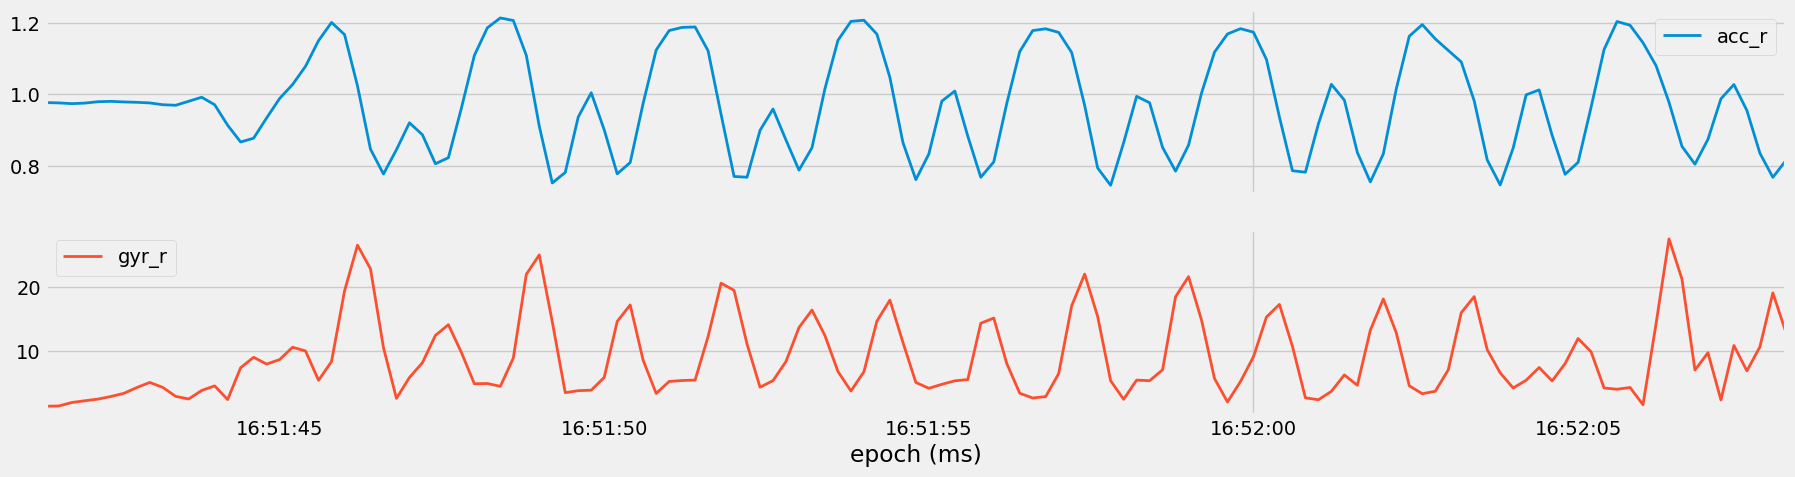

In [58]:
subset[["acc_r", "gyr_r"]].plot(subplots=True)

In [60]:
del df_squared["duration"]

In [61]:
df_squared

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,pca_1,pca_2,pca_3,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,64,-0.317491,-0.075816,0.070520,0.979670,3.229288
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,64,-0.315555,-0.075282,0.070565,0.972630,2.524460
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,64,-0.314780,-0.081915,0.065980,0.966432,4.741409
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,64,-0.316880,-0.090205,0.060065,0.969338,4.269510
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,64,-0.317350,-0.095463,0.063173,0.971528,2.772009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,71,0.346775,-0.147540,-0.051285,0.977783,5.556027
2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,71,0.362725,-0.146231,-0.059154,1.023441,3.727999
2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,71,0.372734,-0.153069,-0.058939,1.054796,2.262446


In [62]:
df_temporal = df_squared.copy()

In [73]:
NumAbs = NumericalAbstraction()

In [79]:
predictor_columns = df_temporal[["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z", "acc_r", "gyr_r"]]

In [80]:
predictor_columns.head()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,acc_r,gyr_r
epoch (ms),,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,0.979670,3.229288
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,0.972630,2.524460
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,0.966432,4.741409
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,0.969338,4.269510
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,0.971528,2.772009


In [82]:
df_temporal

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,pca_1,pca_2,pca_3,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,64,-0.317491,-0.075816,0.070520,0.979670,3.229288
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,64,-0.315555,-0.075282,0.070565,0.972630,2.524460
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,64,-0.314780,-0.081915,0.065980,0.966432,4.741409
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,64,-0.316880,-0.090205,0.060065,0.969338,4.269510
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,64,-0.317350,-0.095463,0.063173,0.971528,2.772009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,71,0.346775,-0.147540,-0.051285,0.977783,5.556027
2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,71,0.362725,-0.146231,-0.059154,1.023441,3.727999
2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,71,0.372734,-0.153069,-0.058939,1.054796,2.262446


In [83]:
predictor_columns = df_temporal[["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z", "acc_r", "gyr_r"]].columns

In [84]:
predictor_columns

Index(['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'acc_r', 'gyr_r'], dtype='object')

In [86]:
ws = int(1000 / 200)

In [87]:
for col in predictor_columns:
    df_temporal = NumAbs.abstract_numerical(df_temporal, [col], ws, "mean")
    df_temporal = NumAbs.abstract_numerical(df_temporal, [col], ws, "std")

In [88]:
df_temporal

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_x_temp_mean_ws_5,gyr_x_temp_std_ws_5,gyr_y_temp_mean_ws_5,gyr_y_temp_std_ws_5,gyr_z_temp_mean_ws_5,gyr_z_temp_std_ws_5,acc_r_temp_mean_ws_5,acc_r_temp_std_ws_5,gyr_r_temp_mean_ws_5,gyr_r_temp_std_ws_5
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,64,...,1.500334,1.975086,-0.794137,2.101951,-0.523681,1.250569,0.971920,0.004416,3.507335,0.858825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,71,...,-11.816937,17.831662,0.603702,5.346850,7.165439,6.227556,1.079434,0.120865,19.162630,14.473459
2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,71,...,-4.923778,12.693305,-1.469373,3.932028,4.409868,5.078760,1.098084,0.102142,11.768908,10.474589
2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,71,...,0.697498,4.394449,-2.997093,1.570800,1.931172,2.207628,1.065057,0.082144,5.749964,2.605498


In [89]:
df_temporal_list = []

In [90]:
for s in df_temporal["set"].unique():
    subset = df_temporal[df_temporal["set"] == s].copy()
    for col in predictor_columns:
        subset = NumAbs.abstract_numerical(subset, [col], ws, "mean")
        subset = NumAbs.abstract_numerical(subset, [col], ws, "std")
    df_temporal_list.append(subset)

In [91]:
pd.concat(df_temporal_list)

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_x_temp_mean_ws_5,gyr_x_temp_std_ws_5,gyr_y_temp_mean_ws_5,gyr_y_temp_std_ws_5,gyr_z_temp_mean_ws_5,gyr_z_temp_std_ws_5,acc_r_temp_mean_ws_5,acc_r_temp_std_ws_5,gyr_r_temp_mean_ws_5,gyr_r_temp_std_ws_5
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,64,...,1.500334,1.975086,-0.794137,2.101951,-0.523681,1.250569,0.971920,0.004416,3.507335,0.858825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,71,...,-11.816937,17.831662,0.603702,5.346850,7.165439,6.227556,1.079434,0.120865,19.162630,14.473459
2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,71,...,-4.923778,12.693305,-1.469373,3.932028,4.409868,5.078760,1.098084,0.102142,11.768908,10.474589
2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,71,...,0.697498,4.394449,-2.997093,1.570800,1.931172,2.207628,1.065057,0.082144,5.749964,2.605498


In [92]:
df_temporal = pd.concat(df_temporal_list)

In [98]:
df_temporal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   acc_x                 9009 non-null   float64
 1   acc_y                 9009 non-null   float64
 2   acc_z                 9009 non-null   float64
 3   gyr_x                 9009 non-null   float64
 4   gyr_y                 9009 non-null   float64
 5   gyr_z                 9009 non-null   float64
 6   participant           9009 non-null   object 
 7   label                 9009 non-null   object 
 8   category              9009 non-null   object 
 9   set                   9009 non-null   int32  
 10  pca_1                 9009 non-null   float64
 11  pca_2                 9009 non-null   float64
 12  pca_3                 9009 non-null   float64
 13  acc_r                 9009 non-null   float64
 14  gyr_r                 

<AxesSubplot: xlabel='epoch (ms)'>

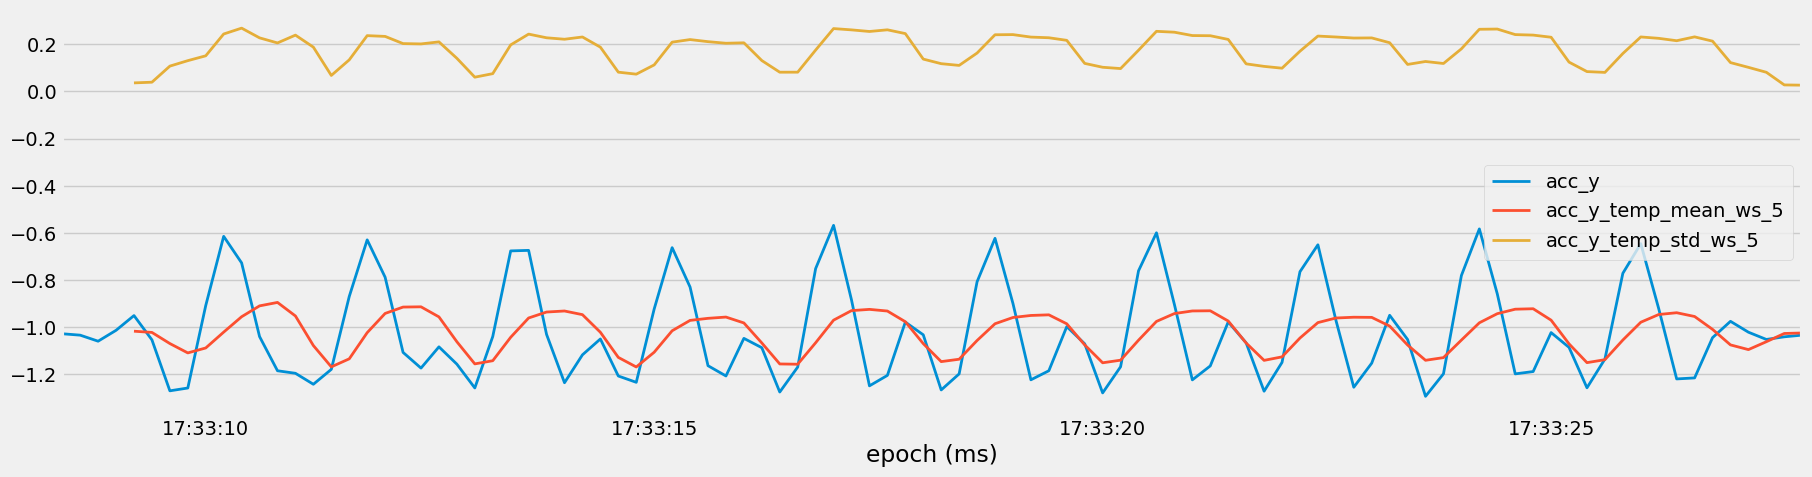

In [99]:
subset[["acc_y", "acc_y_temp_mean_ws_5", "acc_y_temp_std_ws_5"]].plot()

<AxesSubplot: xlabel='epoch (ms)'>

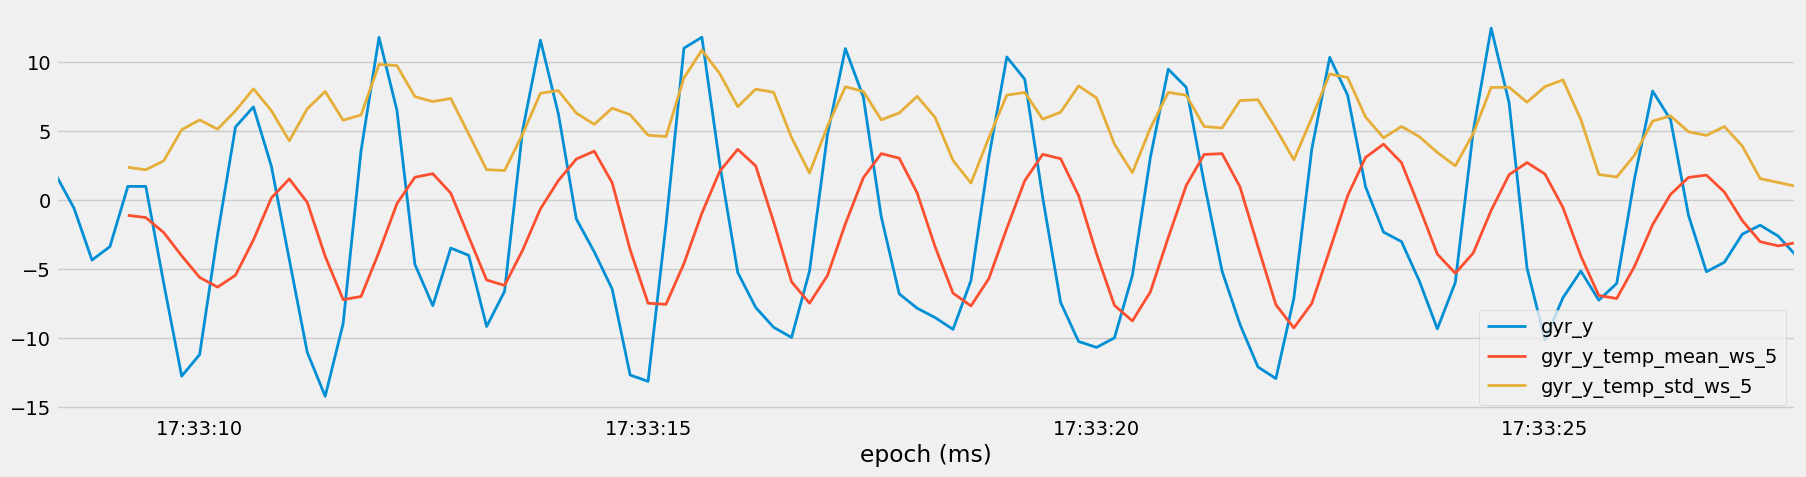

In [100]:
subset[["gyr_y", "gyr_y_temp_mean_ws_5", "gyr_y_temp_std_ws_5"]].plot()

In [101]:
df_freq = df_temporal.copy().reset_index()

In [102]:
df_freq

,epoch (ms),acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,...,gyr_x_temp_mean_ws_5,gyr_x_temp_std_ws_5,gyr_y_temp_mean_ws_5,gyr_y_temp_std_ws_5,gyr_z_temp_mean_ws_5,gyr_z_temp_std_ws_5,acc_r_temp_mean_ws_5,acc_r_temp_std_ws_5,gyr_r_temp_mean_ws_5,gyr_r_temp_std_ws_5
0,2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,...,1.500334,1.975086,-0.794137,2.101951,-0.523681,1.250569,0.971920,0.004416,3.507335,0.858825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9004,2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,...,-11.816937,17.831662,0.603702,5.346850,7.165439,6.227556,1.079434,0.120865,19.162630,14.473459
9005,2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,...,-4.923778,12.693305,-1.469373,3.932028,4.409868,5.078760,1.098084,0.102142,11.768908,10.474589
9006,2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,...,0.697498,4.394449,-2.997093,1.570800,1.931172,2.207628,1.065057,0.082144,5.749964,2.605498
9007,2019-01-20 17:33:27.600,-0.049361,-1.040440,-0.066542,2.411744,-2.591221,0.659428,E,row,medium,...,2.070162,3.565404,-3.299111,1.294202,0.808352,0.406382,1.029788,0.028075,4.916515,2.490629


In [119]:
df_freq = df_temporal.copy().reset_index()

In [120]:
df_freq

,epoch (ms),acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,...,gyr_x_temp_mean_ws_5,gyr_x_temp_std_ws_5,gyr_y_temp_mean_ws_5,gyr_y_temp_std_ws_5,gyr_z_temp_mean_ws_5,gyr_z_temp_std_ws_5,acc_r_temp_mean_ws_5,acc_r_temp_std_ws_5,gyr_r_temp_mean_ws_5,gyr_r_temp_std_ws_5
0,2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,...,1.500334,1.975086,-0.794137,2.101951,-0.523681,1.250569,0.971920,0.004416,3.507335,0.858825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9004,2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,...,-11.816937,17.831662,0.603702,5.346850,7.165439,6.227556,1.079434,0.120865,19.162630,14.473459
9005,2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,...,-4.923778,12.693305,-1.469373,3.932028,4.409868,5.078760,1.098084,0.102142,11.768908,10.474589
9006,2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,...,0.697498,4.394449,-2.997093,1.570800,1.931172,2.207628,1.065057,0.082144,5.749964,2.605498
9007,2019-01-20 17:33:27.600,-0.049361,-1.040440,-0.066542,2.411744,-2.591221,0.659428,E,row,medium,...,2.070162,3.565404,-3.299111,1.294202,0.808352,0.406382,1.029788,0.028075,4.916515,2.490629


In [121]:
FreqAbs = FourierTransformation()

In [123]:
fs = int(1000 / 200)

In [124]:
fs

5

In [125]:
ws = int(2800 / 200)

In [126]:
ws

14

In [130]:
df_freq = FreqAbs.abstract_frequency(df_freq, ["acc_y"], ws, fs)

In [131]:
df_freq

,epoch (ms),acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,...,acc_y_freq_weighted,acc_y_pse,acc_y_freq_0.0_Hz_ws_14,acc_y_freq_0.357_Hz_ws_14,acc_y_freq_0.714_Hz_ws_14,acc_y_freq_1.071_Hz_ws_14,acc_y_freq_1.429_Hz_ws_14,acc_y_freq_1.786_Hz_ws_14,acc_y_freq_2.143_Hz_ws_14,acc_y_freq_2.5_Hz_ws_14
0,2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9004,2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,...,-0.308946,0.071416,-15.116842,0.140688,1.235464,0.862588,0.277972,0.226868,0.221761,0.220843
9005,2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,...,-0.168460,0.078415,-15.554792,-0.443526,1.113321,-0.798544,0.702471,0.305712,0.240305,0.219446
9006,2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,...,0.055361,0.048786,-15.748020,-0.689621,0.563107,-0.977875,0.033320,0.001985,-0.016306,-0.023189
9007,2019-01-20 17:33:27.600,-0.049361,-1.040440,-0.066542,2.411744,-2.591221,0.659428,E,row,medium,...,0.090256,0.026281,-15.590782,-0.479603,-0.061297,0.436001,-0.532645,-0.193088,-0.147901,-0.134657


In [132]:
df_freq.columns

Index(['epoch (ms)', 'acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z',
       'participant', 'label', 'category', 'set', 'pca_1', 'pca_2', 'pca_3',
       'acc_r', 'gyr_r', 'acc_x_temp_mean_ws_5', 'acc_x_temp_std_ws_5',
       'acc_y_temp_mean_ws_5', 'acc_y_temp_std_ws_5', 'acc_z_temp_mean_ws_5',
       'acc_z_temp_std_ws_5', 'gyr_x_temp_mean_ws_5', 'gyr_x_temp_std_ws_5',
       'gyr_y_temp_mean_ws_5', 'gyr_y_temp_std_ws_5', 'gyr_z_temp_mean_ws_5',
       'gyr_z_temp_std_ws_5', 'acc_r_temp_mean_ws_5', 'acc_r_temp_std_ws_5',
       'gyr_r_temp_mean_ws_5', 'gyr_r_temp_std_ws_5', 'acc_y_max_freq',
       'acc_y_freq_weighted', 'acc_y_pse', 'acc_y_freq_0.0_Hz_ws_14',
       'acc_y_freq_0.357_Hz_ws_14', 'acc_y_freq_0.714_Hz_ws_14',
       'acc_y_freq_1.071_Hz_ws_14', 'acc_y_freq_1.429_Hz_ws_14',
       'acc_y_freq_1.786_Hz_ws_14', 'acc_y_freq_2.143_Hz_ws_14',
       'acc_y_freq_2.5_Hz_ws_14'],
      dtype='object')

<AxesSubplot: >

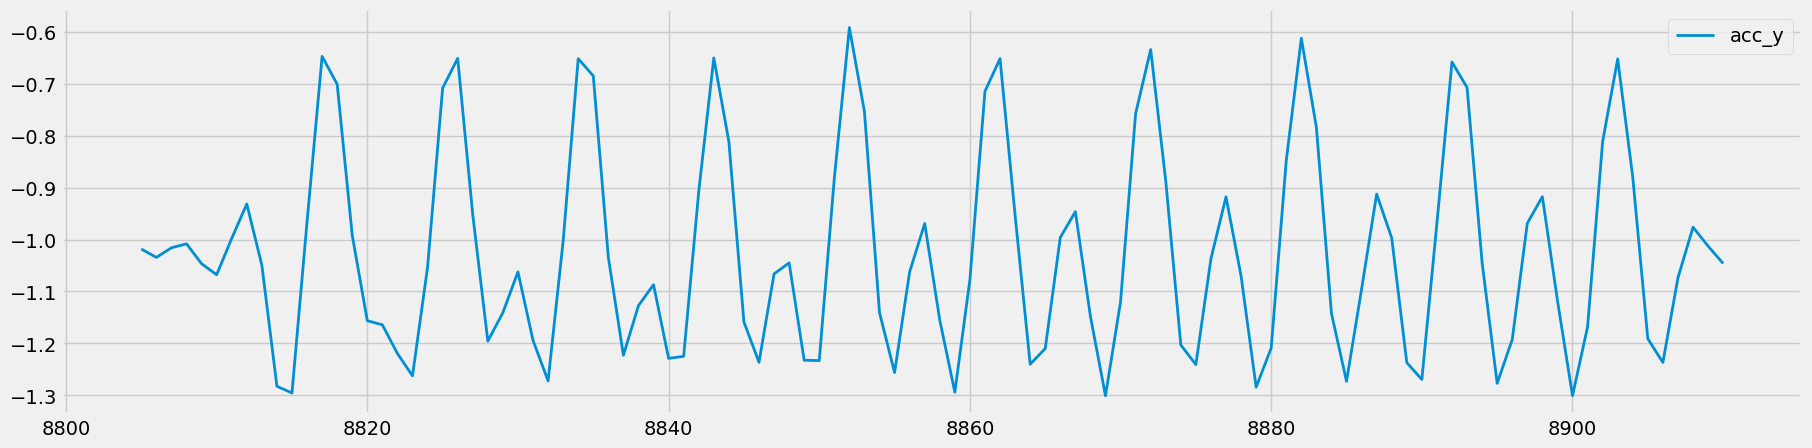

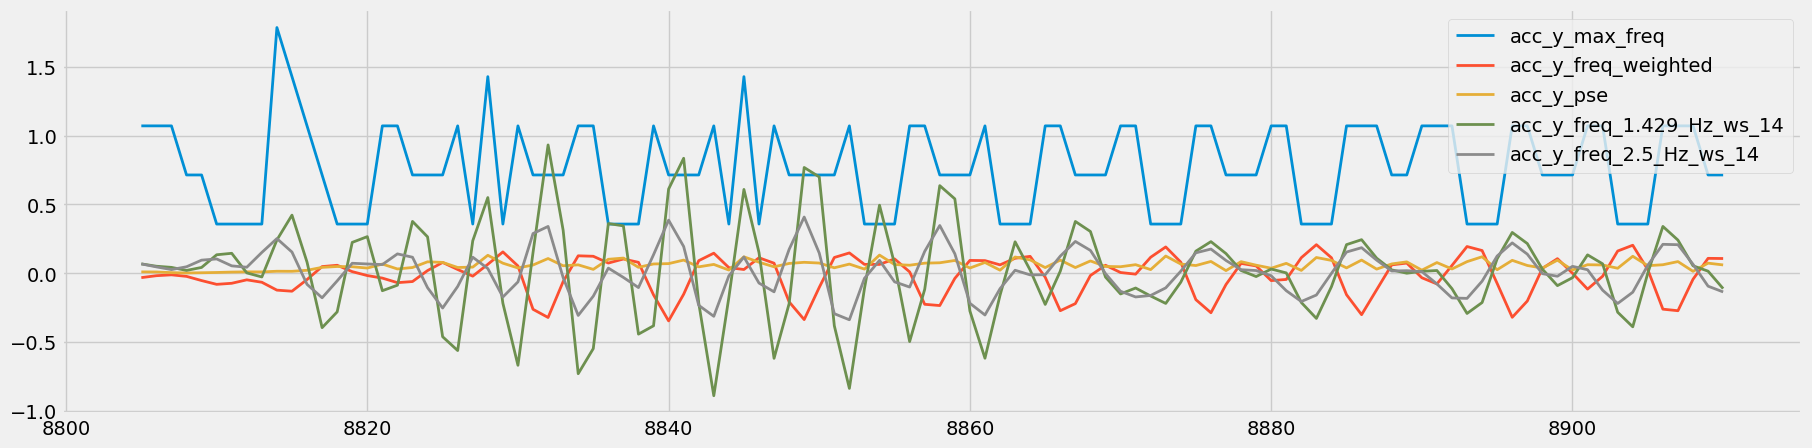

In [135]:
subset = df_freq[df_freq["set"] == 15]
subset[["acc_y"]].plot()
subset[
    [
        "acc_y_max_freq",
        "acc_y_freq_weighted",
        "acc_y_pse",
        "acc_y_freq_1.429_Hz_ws_14",
        "acc_y_freq_2.5_Hz_ws_14",
    ]
].plot()

In [136]:
df_freq_list = []

In [137]:
for s in df_freq["set"].unique():
    print(f"Applying Fourier Transformation to set {s}")
    subset = df_freq[df_freq["set"] == s].reset_index(drop=True).copy()
    subset = FreqAbs.abstract_frequency(subset, predictor_columns, ws, fs)
    df_freq_list.append(subset)

Applying Fourier Transformation to set 64
Applying Fourier Transformation to set 72
Applying Fourier Transformation to set 40
Applying Fourier Transformation to set 86
Applying Fourier Transformation to set 80
Applying Fourier Transformation to set 10
Applying Fourier Transformation to set 74
Applying Fourier Transformation to set 52
Applying Fourier Transformation to set 12
Applying Fourier Transformation to set 33
Applying Fourier Transformation to set 77
Applying Fourier Transformation to set 53
Applying Fourier Transformation to set 32
Applying Fourier Transformation to set 79
Applying Fourier Transformation to set 22
Applying Fourier Transformation to set 17
Applying Fourier Transformation to set 69
Applying Fourier Transformation to set 63
Applying Fourier Transformation to set 60
Applying Fourier Transformation to set 92
Applying Fourier Transformation to set 57
Applying Fourier Transformation to set 7
Applying Fourier Transformation to set 16
Applying Fourier Transformation to 

In [139]:
df_freq = pd.concat(df_freq_list).set_index("epoch (ms)", drop=True)

In [140]:
df_freq

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,71,...,-0.289293,0.211363,315.378553,-32.966667,25.312515,9.456436,-2.814943,-48.443419,-0.900828,-0.225067
2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,71,...,0.509833,0.608660,304.825579,-41.572736,57.022041,78.579281,-21.898935,55.881245,14.102476,9.598016
2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,71,...,0.625087,0.547018,266.538134,-67.414847,35.931545,37.829734,21.948169,22.258871,19.610711,29.452260


In [141]:
df_freq = df_freq.dropna()

In [142]:
df_freq

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:08.000,-0.170494,0.888970,-0.172353,-25.990313,-10.162423,25.426906,B,bench,heavy,64,...,-1.135436,0.401838,227.845540,-29.795388,18.195603,0.294594,-24.424951,11.515400,-51.920406,-13.567962
2019-01-11 15:08:08.200,-0.079459,0.865770,-0.099062,-19.623822,-7.725109,17.802498,B,bench,heavy,64,...,-0.934801,0.340976,252.215177,-22.433493,-19.033819,8.964550,-27.299208,-53.781176,12.732277,-6.323266
2019-01-11 15:08:08.400,-0.027634,0.878027,-0.056321,-4.311919,-1.963210,3.088785,B,bench,heavy,64,...,-0.217733,0.366606,255.346459,-32.701710,-65.942225,-18.156214,5.435095,16.330497,4.416252,-1.494355
2019-01-11 15:08:08.600,-0.035810,0.936473,-0.042505,3.220080,0.392786,-4.260762,B,bench,heavy,64,...,-0.208674,0.558612,255.960168,-39.886136,-71.934733,-23.127344,22.967531,34.012541,-23.505706,5.515086
2019-01-11 15:08:08.800,-0.060139,0.982341,-0.036019,3.691356,-1.273743,-2.492890,B,bench,heavy,64,...,-0.639241,0.432324,256.323480,-40.455694,-30.695845,3.361290,-10.888301,-51.138403,32.709146,-10.263861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,71,...,-0.289293,0.211363,315.378553,-32.966667,25.312515,9.456436,-2.814943,-48.443419,-0.900828,-0.225067
2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,E,row,medium,71,...,0.509833,0.608660,304.825579,-41.572736,57.022041,78.579281,-21.898935,55.881245,14.102476,9.598016
2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,E,row,medium,71,...,0.625087,0.547018,266.538134,-67.414847,35.931545,37.829734,21.948169,22.258871,19.610711,29.452260


In [143]:
df_freq.iloc[::2]

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:08.000,-0.170494,0.888970,-0.172353,-25.990313,-10.162423,25.426906,B,bench,heavy,64,...,-1.135436,0.401838,227.845540,-29.795388,18.195603,0.294594,-24.424951,11.515400,-51.920406,-13.567962
2019-01-11 15:08:08.400,-0.027634,0.878027,-0.056321,-4.311919,-1.963210,3.088785,B,bench,heavy,64,...,-0.217733,0.366606,255.346459,-32.701710,-65.942225,-18.156214,5.435095,16.330497,4.416252,-1.494355
2019-01-11 15:08:08.800,-0.060139,0.982341,-0.036019,3.691356,-1.273743,-2.492890,B,bench,heavy,64,...,-0.639241,0.432324,256.323480,-40.455694,-30.695845,3.361290,-10.888301,-51.138403,32.709146,-10.263861
2019-01-11 15:08:09.200,-0.048152,0.984179,-0.036625,-0.251944,-3.967927,4.930061,B,bench,heavy,64,...,0.479442,0.479839,247.684640,-30.828083,63.975047,6.797325,14.220152,38.695272,24.992977,-4.795215
2019-01-11 15:08:09.600,-0.043981,0.900329,-0.056932,11.319237,5.163204,-10.174713,B,bench,heavy,64,...,-0.431598,0.404515,211.765064,-18.455294,21.941203,9.785602,10.100202,22.696284,-33.412821,-34.036843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:26.200,0.061740,-0.921306,0.112441,-36.980345,7.916154,15.033379,E,row,medium,71,...,-1.224329,0.327550,360.462098,25.374860,-48.513799,15.078979,-48.324601,-33.271836,-18.850747,-34.950958
2019-01-20 17:33:26.600,-0.022066,-1.214770,-0.111567,-4.451577,-1.081130,6.273530,E,row,medium,71,...,0.453873,0.298590,370.584934,34.584916,-17.726772,-16.241214,29.075325,73.198705,23.422109,10.144916
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,71,...,-0.289293,0.211363,315.378553,-32.966667,25.312515,9.456436,-2.814943,-48.443419,-0.900828,-0.225067


In [144]:
df_freq = df_freq.iloc[::2]

In [145]:
from sklearn.cluster import KMeans

In [146]:
df_cluster = df_freq.copy()

In [147]:
cluster_columns = ["acc_x", "acc_y", "acc_z"]
k_values = range(2,10)
inertias = []

In [148]:
k_values = range(2,10)
inertias = []

In [149]:
for k in k_values:
    subset = df_cluster[cluster_columns]
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=0)
    cluster_labels = kmeans.fit_predict(subset)
    inertias.append(kmeans.inertia_)

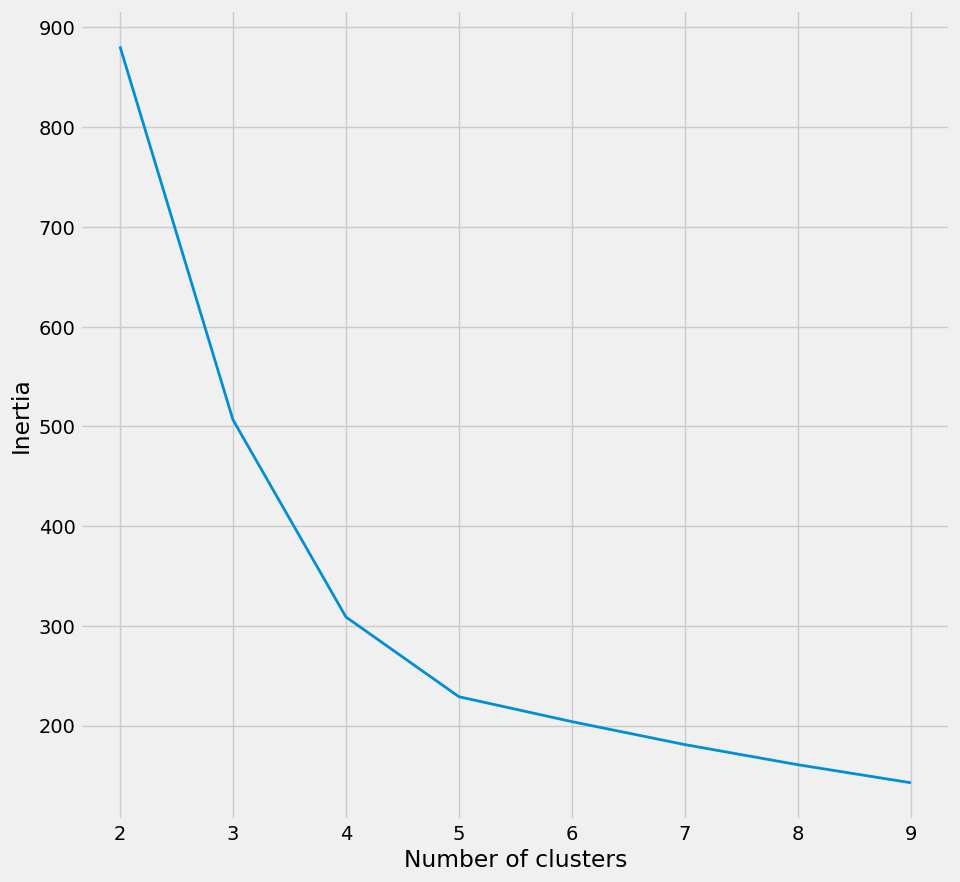

In [150]:
plt.figure(figsize=(10, 10))
plt.plot(k_values, inertias)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [151]:
subset = df_cluster[cluster_columns]
kmeans = KMeans(n_clusters=5, n_init=20, random_state=0)
df_cluster["cluster"] = kmeans.fit_predict(subset)

In [152]:
df_cluster

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14,cluster
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:08.000,-0.170494,0.888970,-0.172353,-25.990313,-10.162423,25.426906,B,bench,heavy,64,...,0.401838,227.845540,-29.795388,18.195603,0.294594,-24.424951,11.515400,-51.920406,-13.567962,0
2019-01-11 15:08:08.400,-0.027634,0.878027,-0.056321,-4.311919,-1.963210,3.088785,B,bench,heavy,64,...,0.366606,255.346459,-32.701710,-65.942225,-18.156214,5.435095,16.330497,4.416252,-1.494355,0
2019-01-11 15:08:08.800,-0.060139,0.982341,-0.036019,3.691356,-1.273743,-2.492890,B,bench,heavy,64,...,0.432324,256.323480,-40.455694,-30.695845,3.361290,-10.888301,-51.138403,32.709146,-10.263861,0
2019-01-11 15:08:09.200,-0.048152,0.984179,-0.036625,-0.251944,-3.967927,4.930061,B,bench,heavy,64,...,0.479839,247.684640,-30.828083,63.975047,6.797325,14.220152,38.695272,24.992977,-4.795215,0
2019-01-11 15:08:09.600,-0.043981,0.900329,-0.056932,11.319237,5.163204,-10.174713,B,bench,heavy,64,...,0.404515,211.765064,-18.455294,21.941203,9.785602,10.100202,22.696284,-33.412821,-34.036843,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:26.200,0.061740,-0.921306,0.112441,-36.980345,7.916154,15.033379,E,row,medium,71,...,0.327550,360.462098,25.374860,-48.513799,15.078979,-48.324601,-33.271836,-18.850747,-34.950958,4
2019-01-20 17:33:26.600,-0.022066,-1.214770,-0.111567,-4.451577,-1.081130,6.273530,E,row,medium,71,...,0.298590,370.584934,34.584916,-17.726772,-16.241214,29.075325,73.198705,23.422109,10.144916,1
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,E,row,medium,71,...,0.211363,315.378553,-32.966667,25.312515,9.456436,-2.814943,-48.443419,-0.900828,-0.225067,1


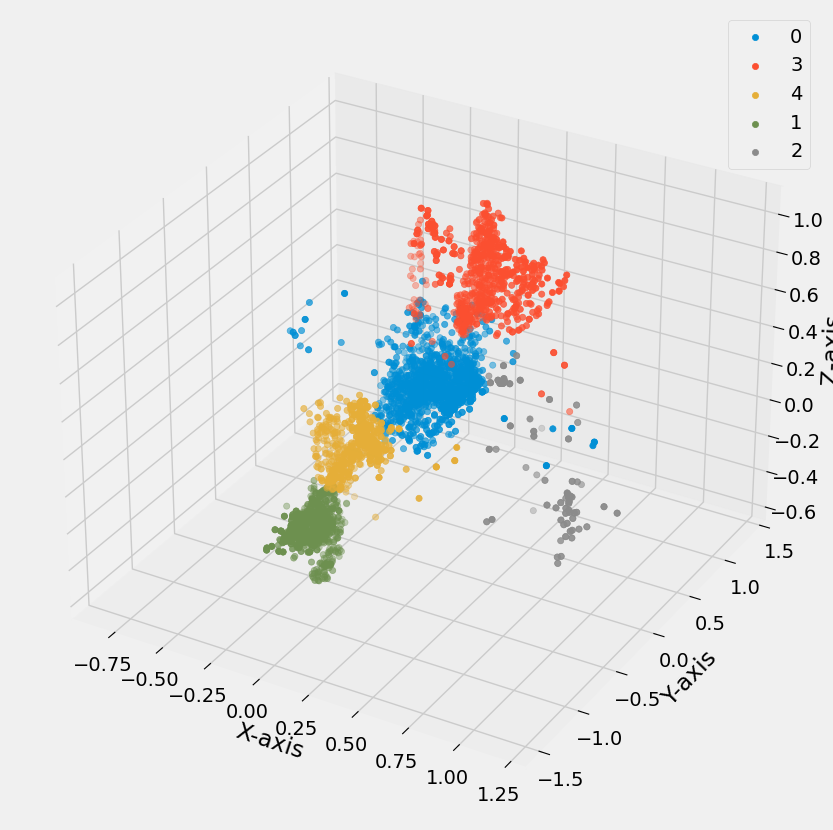

In [153]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
for c in df_cluster["cluster"].unique():
    subset = df_cluster[df_cluster["cluster"] == c]
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label=c)

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.legend()
plt.show()

In [154]:
df_cluster.to_pickle("../../data/interim/03_data_features.pkl")